In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import torchvision

import librosa

from pathlib import Path
from torchvision import transforms

cwd = Path(os.getcwd()).parent
input_dir = Path(cwd, "data", "audio", "recordings")
output_dir = Path(cwd, "data", "audio", "spec")
output_dir.mkdir(exist_ok=True)

In [18]:
for filepath in input_dir.iterdir():
    print(filepath)

/home/zheri/Projects/signal-processing-demo/data/audio/recordings/4_lucas_8.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/7_jackson_33.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/4_george_16.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/2_nicolas_4.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/3_jackson_43.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/0_yweweler_21.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/1_george_8.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/8_yweweler_20.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/9_george_6.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/5_theo_3.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/7_lucas_21.wav
/home/zheri/Projects/signal-processing-demo/data/audio/recordings/8_yweweler_14.wav
/home/zheri/Proj

In [28]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

def save_spectrogram(specgram, save_path=None):
    fig, ax = plt.subplots()

    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest"
    )

    # Remove everything that looks like a label
    ax.axis("off")

    # Remove padding around the image
    plt.tight_layout(pad=0)

    if save_path is not None:
        plt.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
            pad_inches=0
        )
        plt.close(fig)
    else:
        plt.show()



def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [19]:
filename = "0_yweweler_21.wav"
print("Loading " + filename)
sample, fs = torchaudio.load(Path(input_dir, filename))

Loading 0_yweweler_21.wav


### STFT

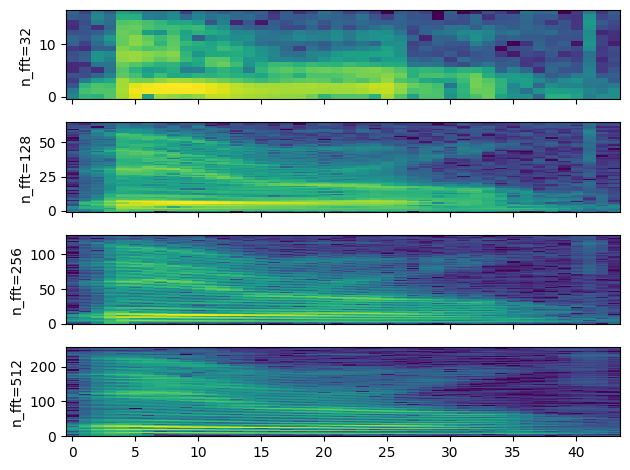

In [29]:
n_ffts = [32, 128, 256, 512]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(sample)
    specs.append(spec)

fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

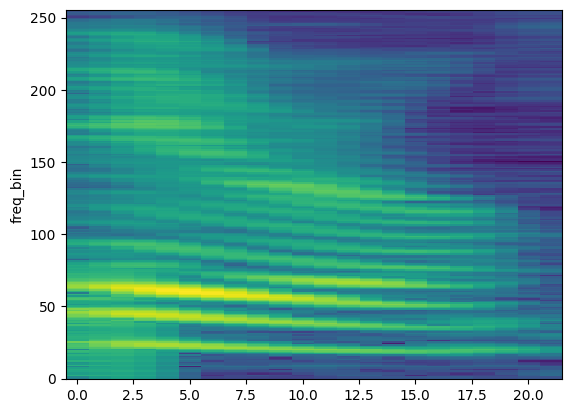

In [48]:
n_fft = 1024
win_length = None
hop_length = 128
n_mels = 256

mel_spectrogram = T.MelSpectrogram(
    sample_rate=fs,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(sample)
plot_spectrogram(melspec[0])

### GoogleNet preprocessing

```python
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
```

# Batch preprocessing

In [58]:
def preprocess(input_dir: Path, output_dir: Path, n_fft: int = 1024, hop_length: int = 256, win_length: int = None, n_mels: int = 128) -> None:
    print("Loading from " + str(input_dir))

    for filepath in input_dir.iterdir():
        fname = filepath.name
        fstem = filepath.stem
        ftype = filepath.suffix
        
        print("Loading " + fname)
        data, fs = torchaudio.load(filepath)

        print("Generating spectrogram for " + fname)
        mel_spectrogram = T.MelSpectrogram(
            sample_rate=fs,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            n_mels=n_mels,
            mel_scale="htk",
        )
        melspec = mel_spectrogram(data)

        out = Path(output_dir, f"{fstem}.png")
        print("Saving to", out)
        save_spectrogram(melspec[0], out)

    print("Done!")
        
preprocess(input_dir, output_dir)

Loading from /home/zheri/Projects/signal-processing-demo/data/audio/recordings
Loading 4_lucas_8.wav
Generating spectrogram for 4_lucas_8.wav
Saving to /home/zheri/Projects/signal-processing-demo/data/audio/spec/4_lucas_8.png
Loading 7_jackson_33.wav
Generating spectrogram for 7_jackson_33.wav
Saving to /home/zheri/Projects/signal-processing-demo/data/audio/spec/7_jackson_33.png
Loading 4_george_16.wav
Generating spectrogram for 4_george_16.wav
Saving to /home/zheri/Projects/signal-processing-demo/data/audio/spec/4_george_16.png
Loading 2_nicolas_4.wav
Generating spectrogram for 2_nicolas_4.wav
Saving to /home/zheri/Projects/signal-processing-demo/data/audio/spec/2_nicolas_4.png
Loading 3_jackson_43.wav
Generating spectrogram for 3_jackson_43.wav
Saving to /home/zheri/Projects/signal-processing-demo/data/audio/spec/3_jackson_43.png
Loading 0_yweweler_21.wav
Generating spectrogram for 0_yweweler_21.wav
Saving to /home/zheri/Projects/signal-processing-demo/data/audio/spec/0_yweweler_21.p